<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week9/Day4/XP_Exercises/XP_Exercise_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ab-test-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2479030%2F4213024%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T154728Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0eebc6ebd0bed8f8622dc376def453786d466775ac55063545079125527d3216376025187d7cf4905cb4e415abfe901c3034bb5c1d27c4556ce6bc54bf12fc2e16c75d0dd65edac1b9fdab9459cc3754475a2c615d0fe4fc72c211664d501649321b9f0b6b399d32de456f2af97b34dabf629c3970310642437a477bf51de9eed35c73250b723e787bab84b578e98da2182ef1a402621aa0a4a34f6e8bda5e024739abe4167877ea5de0105f7907a971e6ddcb044567e92ac0964f921cb9aa49abf89cbdd811bcb6a11e893836e236fe55ef1bd2ad18bb6cf540a5e71ffdd8a094a38a4e30f7f2048143007689c34425d3bd78bcbb7fe1c0ea8e34f4b8d2881d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 28963 bytes downloaded
Downloaded and uncompressed: ab-test-data
Data source import complete.


The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
path = '/kaggle/input/ab-test-data/AB_Test_Results.csv'
df = pd.read_csv(path)

In [4]:
# TODO : take a quick look at the data

In [5]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,10000.0,4981.080200,2890.590115,2.0,2468.75,4962.0,7511.5,10000.00
REVENUE,10000.0,0.099447,2.318529,0.0,0.00,0.0,0.0,196.01


In [8]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [9]:
df.duplicated().sum()

2067

In [10]:
# # Getting read of the duplicated values
# df=df.drop_duplicates()
df.shape

(10000, 3)

Let's see if there are users who have two A/B test groups

In [11]:
# TODO : Look at the distribution of the number of unique groups for each user

two_test_user = df[df['USER_ID'].duplicated() == True]
two_test_user.sort_values(by='USER_ID')

group_user = df.groupby(['USER_ID','VARIANT_NAME']).size().unstack(level='VARIANT_NAME',fill_value=0)

# unique_group_user = unique_group_user.reset_index(name='Count test')
group_user['Total_Group'] =  group_user['control']+group_user['variant']


# Reset the index to make 'USER_ID' a column again
group_user = group_user.reset_index()

# Display the resulting DataFrame
print(group_user)

VARIANT_NAME  USER_ID  control  variant  Total_Group
0                   2        3        0            3
1                   3        1        2            3
2                   4        0        1            1
3                   5        0        1            1
4                   6        0        1            1
...               ...      ...      ...          ...
6319             9993        1        0            1
6320             9995        0        2            2
6321             9996        1        1            2
6322             9998        1        0            1
6323            10000        1        2            3

[6324 rows x 4 columns]


In [12]:
multiple_test = group_user[group_user['Total_Group']>=2]
multiple_test

VARIANT_NAME,USER_ID,control,variant,Total_Group
0,2,3,0,3
1,3,1,2,3
6,10,1,1,2
7,11,2,0,2
9,13,2,0,2
...,...,...,...,...
6313,9982,1,1,2
6315,9986,0,2,2
6320,9995,0,2,2
6321,9996,1,1,2


   control  control duplicated
0        1                1192
1        2                 775
2        3                 115
3        4                  13
4        5                   1
5        6                   1


Text(0.5, 1.0, 'Distribution Control Duplicated')

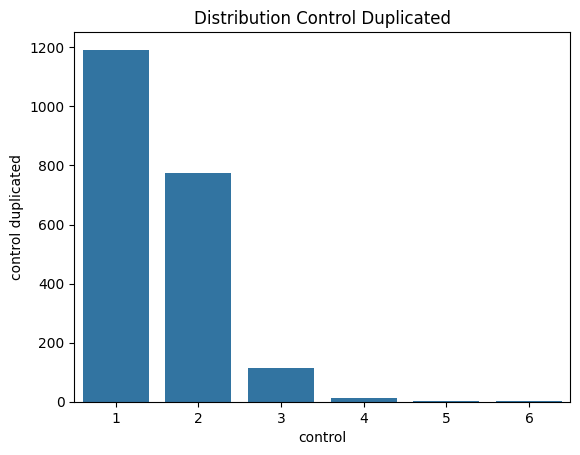

In [13]:
df_control = multiple_test[multiple_test['control']>0]
df_control = df_control.groupby('control')['control'].count().reset_index(name='control duplicated')
print(df_control)

sns.barplot(data=df_control, x= 'control', y= 'control duplicated')
plt.title('Distribution Control Duplicated')

   variant  variant count duplicated
0        1                      1180
1        2                       790
2        3                       111
3        4                        22
4        5                         1


Text(0.5, 1.0, 'Distribution Variant Duplicated')

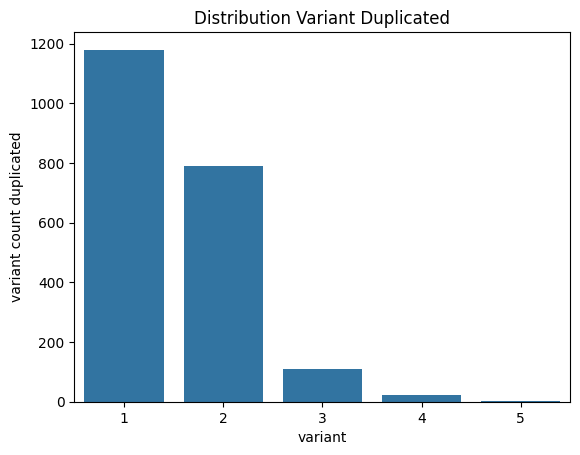

In [14]:
df_variant = multiple_test[multiple_test['variant']>0]
df_variant = df_variant.groupby('variant')['variant'].count().reset_index(name='variant count duplicated')
print(df_variant)
sns.barplot(data=df_variant, x= 'variant', y= 'variant count duplicated')
plt.title('Distribution Variant Duplicated')

In [15]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms


What can you observe ? Should we exclude these users ? Why ?

In [16]:
# TODO : users have 1 A/B test group ?

print(len(group_user[group_user['Total_Group']==1]))

# TODO : Take only these users
one_test_user = group_user[group_user['Total_Group']==1]
one_test_user

3664


VARIANT_NAME,USER_ID,control,variant,Total_Group
2,4,0,1,1
3,5,0,1,1
4,6,0,1,1
5,9,0,1,1
8,12,1,0,1
...,...,...,...,...
6316,9989,1,0,1
6317,9990,0,1,1
6318,9992,1,0,1
6319,9993,1,0,1


In [17]:
# TODO : Leave only records with users with the 1st ab test group
control_user = one_test_user[one_test_user['control']==1]

# TODO : Check that the number of users matches what it was before the exception


Let's see how the data is distributed

In [18]:
df.columns

Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')

<Axes: xlabel='REVENUE'>

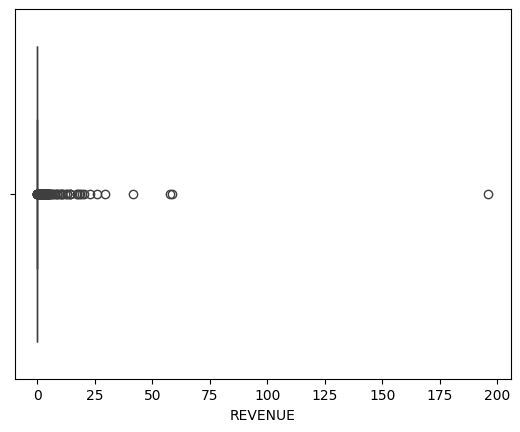

In [19]:
# TODO : Check how the data is distributed using a box plot
sns.boxplot(data = df, x= 'REVENUE')

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [20]:
# TODO : Sort these revenue values in descending order
df_sorted= df.sort_values(by='REVENUE',ascending=False)
df_sorted

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
...,...,...,...
3356,7969,variant,0.00
3357,1184,control,0.00
3358,3775,variant,0.00
3359,6745,control,0.00


In [21]:
# TODO : See if user 3342 had other events with a strong outlier

user_3342 = df[df['USER_ID']==3342]
user_3342

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<Axes: xlabel='REVENUE'>

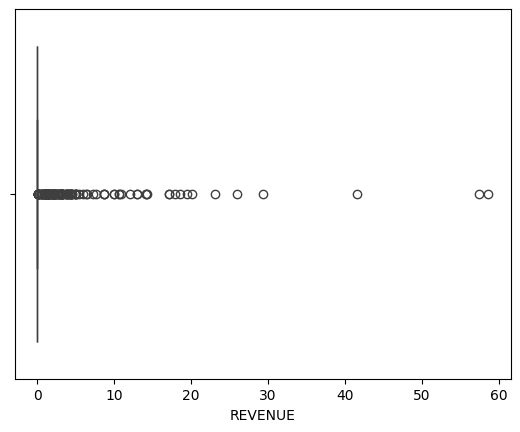

In [22]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df = df[df['USER_ID']!=3342]

sns.boxplot(data=df, x= 'REVENUE')


What can you say about the users and their purchases ?

In [23]:
# TODO : Check if there are users who have records with zero and positive revenue
users_no_rev = (df['REVENUE']==0).sum()
print("no revenue:", users_no_rev)

user_with_rev = (df['REVENUE']>0).sum()
print("with revenue:",user_with_rev)

no revenue: 9848
with revenue: 151


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [24]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
revenue_user = df.groupby('USER_ID')['REVENUE'].sum()
revenue_user = revenue_user.reset_index(name='Total Revenue')
revenue_user=revenue_user[revenue_user['Total Revenue']!=0]
revenue_user

,USER_ID,Total Revenue
32,56,2.99
75,124,1.25
104,169,4.33
174,282,18.56
252,403,1.99
...,...,...
6121,9669,1.99
6183,9766,3.79
6275,9928,1.25
6287,9942,3.25


<Axes: xlabel='Total Revenue', ylabel='Count'>

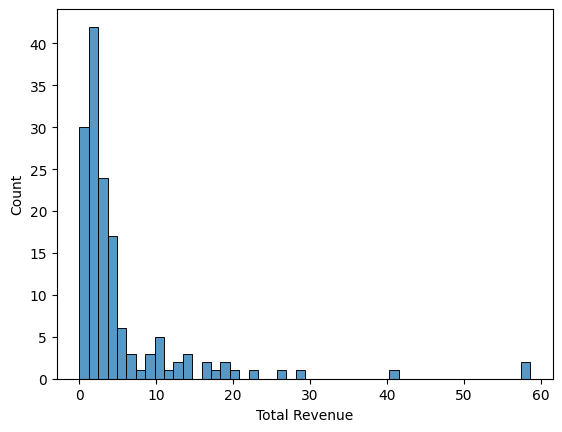

In [25]:
# TODO : Visualize the resulting distribution of the data again.
sns.histplot(data=revenue_user, x= 'Total Revenue')

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [26]:
# TODO : get metrics by groups

metrics_by_group = df.groupby('VARIANT_NAME').agg(
    avg_revenue=('REVENUE', 'mean'),
    total_revenue=('REVENUE', 'sum'),
    user_count=('USER_ID', 'count')
).reset_index()

print(metrics_by_group)

# TODO : create two additional metrics to see relative changes

control_user = metrics_by_group[metrics_by_group['VARIANT_NAME']== 'control']
variant_user = metrics_by_group[metrics_by_group['VARIANT_NAME']== 'variant']

control_user_revenue = control_user['total_revenue'].values[0]
variant_user_revenue = variant_user['total_revenue'].values[0]

revenue_change = (variant_user_revenue-control_user_revenue) / control_user_revenue

print(round(revenue_change * 100, 2), "%  Change in revenue")


control_user_count = control_user['user_count'].values[0]
variant_user_count = variant_user['user_count'].values[0]

user_count_change = (variant_user_count-control_user_count) / control_user_count

print(round(user_count_change * 100, 2), "% Change in number of users" )


# TODO : add them to the rest of the metrics in a separate group


  VARIANT_NAME  avg_revenue  total_revenue  user_count
0      control     0.089703         446.99        4983
1      variant     0.070070         351.47        5016
-21.37 %  Change in revenue
0.66 % Change in number of users


Let's look at the distributions of all and only paying users

<ipython-input-27-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-27-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

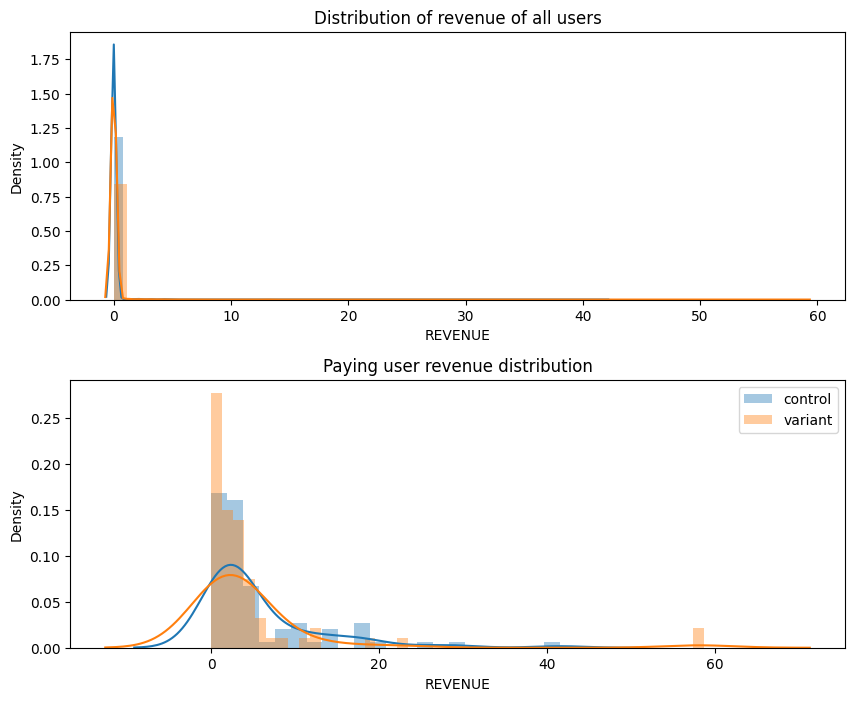

In [27]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [28]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

shapiro(df['REVENUE'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.037388384342193604, pvalue=0.0)

Test Statistic (0.0374): The test statistic is a measure of how closely the sample data resembles a normal distribution. A value closer to 1 indicates that the data is more normally distributed. Since the test statistic is quite low, it suggests that the sample data deviates significantly from a normal distribution.

p-value (0.0): The p-value is the probability of obtaining the observed results (or more extreme results) if the null hypothesis is true. In this case, a p-value of 0.0 indicates that the probability of obtaining the observed deviation from normality, or more extreme deviation, assuming the data is normally distributed, is effectively zero.

With such a low p-value, typically below the standard significance level of 0.05, we reject the null hypothesis that the data is normally distributed. This means that the sample data is not normally distributed.

Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [29]:
(df['REVENUE'] == 0).value_counts()

REVENUE
True     9848
False     151
Name: count, dtype: int64

In [36]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [49]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
from scipy.stats import mannwhitneyu

# divide dataset for variant and control
df_variant = df[df['VARIANT_NAME']=='variant']['REVENUE']
df_control = df[df['VARIANT_NAME']=='control']['REVENUE']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(df_variant, df_control)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two datasets.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two datasets.")


Mann-Whitney U statistic: 12478180.0
P-value: 0.5291970335120277
Fail to reject the null hypothesis: There is no significant difference between the two datasets.


In [46]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

# divide dataset for variant and control without considering revenue = 0
df_pay = df[df['REVENUE']!=0]
df_variant_pay = df_pay[df_pay['VARIANT_NAME']=='variant']['REVENUE']
df_control_pay = df_pay[df_pay['VARIANT_NAME']=='control']['REVENUE']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(df_variant_pay, df_control_pay)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two datasets.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two datasets.")


Mann-Whitney U statistic: 2404.0
P-value: 0.10145877111519161
Fail to reject the null hypothesis: There is no significant difference between the two datasets.


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [44]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [52]:
# TODO : Generate samples for all users
df_variant = df[df['VARIANT_NAME']=='variant']['REVENUE'].ravel()
df_control = df[df['VARIANT_NAME']=='control']['REVENUE'].ravel()

df_variant_ = get_bootstrap_samples(df_variant)
df_control_= get_bootstrap_samples(df_control)

In [53]:
# TODO : Generate samples for only paying users
df_pay = df[df['REVENUE']!=0]
df_variant_pay = df_pay[df_pay['VARIANT_NAME']=='variant']['REVENUE'].ravel()
df_control_pay = df_pay[df_pay['VARIANT_NAME']=='control']['REVENUE'].ravel()

df_variant_pay_ = get_bootstrap_samples(df_variant_pay)
df_control_pay_= get_bootstrap_samples(df_control_pay)

Let's look at the distribution of means in the ab test groups

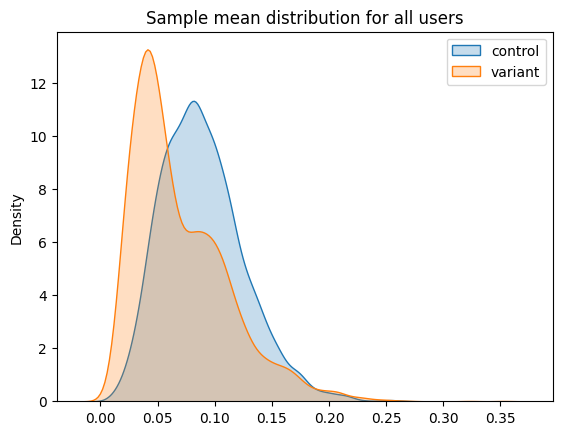

In [57]:
import warnings

# Suppress FutureWarnings temporarily
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Your plotting code here
    sns.kdeplot(np.mean(df_control_, axis=0), shade=True, label='control')
    sns.kdeplot(np.mean(df_variant_, axis=0), shade=True, label='variant')
    plt.legend()

plt.title('Sample mean distribution for all users')
plt.legend()


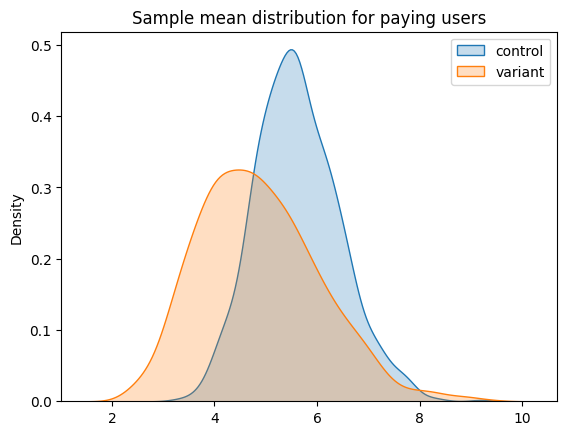

In [60]:
import warnings

with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=FutureWarning)
  f, ax = plt.subplots()
  # plt.figure(figsize=(20,5))
  sns.kdeplot(np.mean(df_control_pay_, axis=1), shade=True, label='control')
  sns.kdeplot(np.mean(df_variant_pay_, axis=1), shade=True, label='variant')

plt.title('Sample mean distribution for paying users')
plt.legend()
plt.show()

There is no a significant difference between both groups

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [61]:
def plot_distribution_and_stat_intervals(variant, control, title='Distribution and Confidence Intervals', alpha=0.05):
    # Plot the distribution of the difference between variant and control
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    kde_plot = sns.kdeplot(variant - control, fill=True)
    points = kde_plot.collections[0].get_paths()[0].vertices
    x = points[:, 0]
    y = points[:, 1]
    plt.fill_between(x, y, where=(x >= np.percentile(x, 100 * alpha / 2.)) & (x <= np.percentile(x, 100 * (1 - alpha / 2.))), alpha=0.3)

    # Plot the kernel density estimate
    sns.kdeplot(variant - control, label='Distribution', shade=True)

    # Calculate and plot confidence intervals
    confidence_intervals = stat_intervals(variant - control, alpha=alpha)
    plt.axvline(x=confidence_intervals[0], color='r', linestyle='--', label=f'{100*(1-alpha)}% CI')
    plt.axvline(x=confidence_intervals[1], color='r', linestyle='--')

    plt.title(title)
    plt.xlabel('Difference between Variant and Control')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

<ipython-input-61-3a71a0eb3084>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(variant - control, label='Distribution', shade=True)


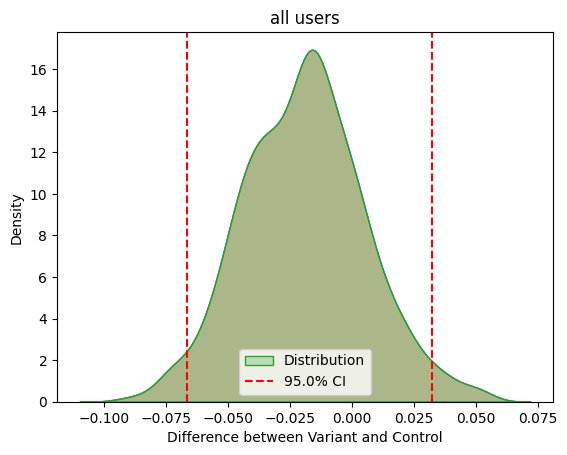

In [62]:
plot_distribution_and_stat_intervals(np.mean(df_variant_, axis=1),
                                     np.mean(df_control_, axis=1),
                                     title='all users')

<ipython-input-61-3a71a0eb3084>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(variant - control, label='Distribution', shade=True)


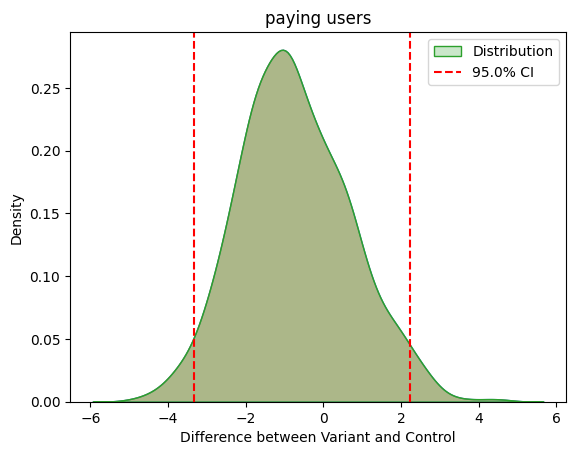

In [63]:
plot_distribution_and_stat_intervals(np.mean(df_variant_pay_, axis=1),
                                     np.mean(df_control_pay_, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


Based on the plots and the analysis made before I can conclude that there is not a significant difference between both test groups.

The statisics showed for the diverse methodologies that the p values are always higher than our confidence interval, meaning that we fail to reject the null hypothesis: There is no significant difference between the two datasets.

